In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
from jax import config
config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from functools import partial
import optax
import pandas as pd
from utils import *

import set_rcParams

In [35]:
# Construct the dataframe
SWEEP_IDS = [
    "RESULT_OF_scans/varying_number_heads",
]
OG_df = pd.concat([load_sweep(id, last_step_only=False) for id in SWEEP_IDS])
OG_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Average across seeds (take mean + std)
df_comp = OG_df.groupby(["_step", "rnn_n_heads", "lr_base"])[["Training loss", "Mean LR/params.VmapVmapRNNBase_0.A"]].mean().reset_index()
df_comp["Training loss std"] = OG_df.groupby(["_step", "rnn_n_heads", "lr_base"])[["Training loss"]].sem().reset_index()["Training loss"]

# Pick the best learning rate for each n_heads, for the last _step
df_select = df_comp[df_comp["_step"] == df_comp["_step"].max()]
df_select = df_select.sort_values("Training loss").groupby("rnn_n_heads").first().reset_index()
map_n_heads_lr = {
    df_select["rnn_n_heads"][i]: df_select["lr_base"][i] for i in range(len(df_select))
}
final_df = [
    df_comp[(df_comp["rnn_n_heads"] == n_heads) & (df_comp["lr_base"] == map_n_heads_lr[n_heads])]
    for n_heads in map_n_heads_lr
]

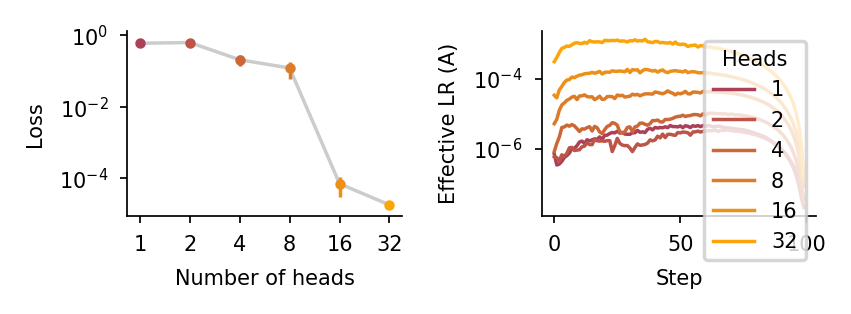

In [41]:
COLORS_RED = [
    "#AC4056",
    "#bc5447",
    "#cc6837",
    "#dc7c28",
    "#ec9019",
    "#FCA50A",
]

fig, ax = plt.subplots(1, 2, figsize=(3.5, 1.35))

last_step_df = [df[df["_step"] == df["_step"].max()] for df in final_df]
ax[0].plot(
    [df["rnn_n_heads"].values[0] for df in last_step_df],
    [df["Training loss"].item() for df in last_step_df],
    linestyle="-", linewidth=1, color = "#CCCCCC"
)
for i, d in enumerate(last_step_df):
    ax[0].errorbar(d["rnn_n_heads"].values[0], d["Training loss"].item(), yerr=d["Training loss std"].item(), fmt="o", markersize=2, color=COLORS_RED[i])

ax[0].set_yscale("log")
ax[0].set_ylabel("Loss")
ax[0].set_xscale("log")
ax[0].set_xlabel("Number of heads")
ax[0].set_xticks([1, 2, 4, 8, 16, 32], [1, 2, 4, 8, 16, 32])
ax[0].minorticks_off()

for i, d in enumerate(final_df):
    ax[1].plot(
        d["_step"],
        d["Mean LR/params.VmapVmapRNNBase_0.A"],
        linestyle="-", linewidth=1, color = COLORS_RED[i], label=f"{d['rnn_n_heads'].values[0]}"
    )
ax[1].set_xlabel("Step")
ax[1].set_ylabel("Effective LR (A)")
ax[1].set_yscale("log")
ax[1].legend(title="Heads", loc="upper right", fontsize=6)

plt.tight_layout()